In [180]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [181]:
#unpack our learning dataset
words = open('names.txt','r').read().splitlines()
words[:6]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte']

In [182]:
#Vocabulary of characters an mappings from/to integers

chars = sorted(list(set(''.join(words)))) # concatenate all dataset as a sinle string and passes it thru the set constructor

stoi = {s:i+1 for i,s in enumerate(chars)} # stoi maps a-0, b-1 and so on til z-25

# what about ourspecial char
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [183]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [184]:
# building the dataset

block_size = 8 # context length: how many char do we take to predict the next one


def build_dataset(words):
    
    X, Y = [], [] #X are input to the NN and Y are the label for each example inside X
    for w in words[:]: #rn first 5 for efficeincy
      #print(w) 
      context = [0] * block_size # padded context of 0 tokens
      for ch in w + '.':
        ix = stoi[ch]     
        X.append(context) # stores the current running context context 
        Y.append(ix) # array y of the current character 
        context = context[1:] + [ix] # crop the context and append new char in sequence

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) #80% of the words
Xdev, Ydev = build_dataset(words[n1:n2])# 90 -80% of the words
Xte, Yte = build_dataset(words[n2:])# remaining words

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [185]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> e
.......e --> b
......eb --> r
.....ebr --> i
....ebri --> m
...ebrim --> a
..ebrima --> .
........ --> h
.......h --> i
......hi --> l
.....hil --> t
....hilt --> o
...hilto --> n
..hilton --> .
........ --> j
.......j --> h
......jh --> e
.....jhe --> n
....jhen --> e
...jhene --> .


In [186]:
# Lets creater a deeper network

# create a linear layer (like the hpreact but more suited for pytorch)
#-------------------------------------------------------------------------------
class Linear:
  def __init__(self, fan_in, fan_out, bias =True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])
#-------------------------------------------------------------------------------

#Batch Normalization Layer
#-------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim) # for when we train the nueral net
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update') (not part of the back propagation)
    self.running_mean = torch.zeros(dim) # for inference (currently averaging over 32 numbers but we want 32* 4 numbers cause x became 3dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0 
      elif x.ndim == 3:
        dim = (0,1) # NOTE: this is a lil diff from pytorch api as we expect (N,L,C) but pytorch expects (N,C,L)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad(): #use this because if you dont then pytorch will star building out an entire computational graph cause it will expect that eventually we will back propagate thru this (call .backward)
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean #exponential moving average
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]
#-------------------------------------------------------------------------------

#Non-Linearity
#-------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
#-------------------------------------------------------------------------------

#Embedding Module
# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------

#Flattening operation
# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
    
  def __init__(self, n):
    self.n = n  
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)

    self.out = x
    return self.out
  
  def parameters(self):
    return []
# -----------------------------------------------------------------------------------------------

#Sequential Container (a container is a way of organizing the layers check documentation for more details)
# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]
#--------------------------------------------------------------------------------------




In [187]:
torch.manual_seed(42); #seed rng for reproducibility

In [198]:
n_embd = 24 #10 # the dimensionality of the character embedding vectors
n_hidden = 128 # 200 # the number of neurons in the hidden layer of the MLP
#g = torch.Generator().manual_seed(2147483647) # for reproducibility


#layers with batch norm (ususally between linear layer and non linearity but we can try to paly around to suit some specific purposes)
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),# bias=False), BatchNorm1d(vocab_size)
])


with torch.no_grad():
  # last layer: make less confident
  #layers[-1].gamma *= 0.1 # for batchnorm
  model.layers[-1].weight *= 0.1
  # all other layers: apply gain
  # for layer in layers[:-1]:
  #   if isinstance(layer, Linear):
  #     layer.weight *= 5/3 #1.0 

parameters = model.parameters() # embedding matrix
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [199]:
# lets look at a batch of just 5 examples
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0, 12, 25, 14],
        [ 0,  0, 20, 18,  5, 19,  8,  1],
        [ 0,  0,  0,  0,  0, 10,  1,  7],
        [ 0,  0,  0,  0,  0, 14,  5,  9]])

In [200]:
#inspect the shapes
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [201]:
model.layers[0].out.shape # output of embedding layer

torch.Size([4, 8, 24])

In [202]:
model.layers[1].out.shape # output of Flatten layer

torch.Size([4, 4, 48])

In [203]:
model.layers[2].out.shape # output of Linear layer

torch.Size([4, 4, 128])

In [204]:
(torch.randn(4,4,20) @ torch.randn(20,200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [205]:
list(range(10))[1::2]

[1, 3, 5, 7, 9]

In [206]:
list(range(10))[::2]

[0, 2, 4, 6, 8]

In [207]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else (0.01 if i < 150000 else 0.001) # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters]) # keeping track of the update to data ratio (update is lr * grad)

  #if i >= 1000:
  #break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2845
  10000/ 200000: 1.6439
  20000/ 200000: 2.3351
  30000/ 200000: 2.1386
  40000/ 200000: 1.9069
  50000/ 200000: 2.1104
  60000/ 200000: 2.0582
  70000/ 200000: 1.7767
  80000/ 200000: 2.0560
  90000/ 200000: 2.1184
 100000/ 200000: 1.8950
 110000/ 200000: 1.8403
 120000/ 200000: 1.4877
 130000/ 200000: 1.6541
 140000/ 200000: 1.8638
 150000/ 200000: 1.7060
 160000/ 200000: 1.9391
 170000/ 200000: 2.0486
 180000/ 200000: 1.3970
 190000/ 200000: 1.5697


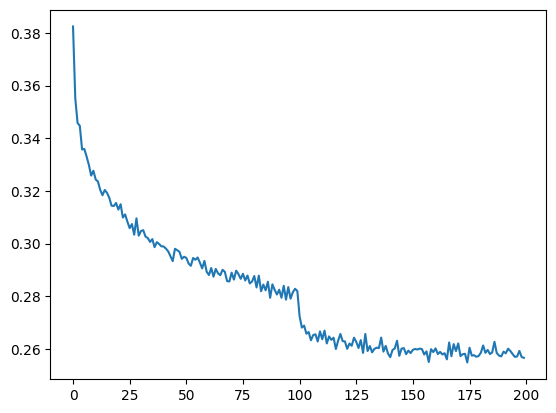

In [208]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [209]:
# put layers in eval mode (crucial for batchnorm)
for layer in model.layers:
  layer.training = False

In [210]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7935439348220825
val 1.9802156686782837


**Performance Log**


*   OG: 3 char context + 200 hidden Nueron --> 12K param --> 2.058 train, 2.105 val
*   Now: 8 char context + 200 hidden Nueron --> 22K param --> 1.93 train, 2.025 val
*   Flat + Bug fix in batchnorm: 1.925 train, 2.020 val
*   scaledup Net: n_embd 24, n_hid 128 (78K param)  1.794 train, 1.980 val 





In [211]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

montay.
yazmine.
madhayla.
remmas.
endra.
graden.
daelin.
shyloh.
leighanno.
aarvell.
kohlynn.
noshub.
rishith.
ston.
joselynn.
novaley.
brenden.
kylene.
ehsyn.
ajayah.


Whats Next ??? CONVOLUTION NN (yaay)
tho its just optimization really. 

In [212]:
# convolution is a "for loop" that allows us to forward the Linear layer more effeciently
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

# were looking at a specific name with 7 chars ==> 8 independent examples in our model


........ --> h
.......h --> i
......hi --> l
.....hil --> t
....hilt --> o
...hilto --> n
..hilton --> .
........ --> j


In [213]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [214]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [215]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space